In [ ]:
import os
import random
import logging
from copy import deepcopy
from collections import defaultdict
from matplotlib import pyplot as plt

import cv2
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

from isegm.utils.log import logger, TqdmToLogger, SummaryWriterAvg
from isegm.utils.vis import draw_probmap, draw_points, add_tag
from isegm.utils.misc import save_checkpoint
from isegm.utils.serialization import get_config_repr
from isegm.utils.distributed import get_dp_wrapper, get_sampler, reduce_loss_dict
from torch.cuda.amp import autocast as autocast, GradScaler

from isegm.utils.exp_imports.default import * 

MODEL_NAME = "lidc_hrnet32"

from isegm.data.compose import ComposeDataset, ProportionalComposeDataset
import torch.nn as nn
from isegm.data.aligned_augmentation import AlignedAugmentator
from isegm.engine.focalclick_trainer import ISTrainer

from isegm.data.compose import ComposeDataset, ProportionalComposeDataset
import torch.nn as nn
from isegm.data.aligned_augmentation import AlignedAugmentator, ProbabilisticAlignedAugmentator
from isegm.engine.focalclick_trainer import ISTrainer
from isegm.data.preprocess import Preprocessor
from albumentations import Compose, PadIfNeeded, RandomCrop

In [ ]:
device = torch.device('cuda:0')

In [ ]:
LIDC_PATH = "/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/train"
LIDC_VAL_PATH = "/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/val"
LIDC_CROPS_PATH = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D-128-CROPS/Tr'

In [ ]:
def visualise_raw_batch(batch):
    print(batch.keys())
    fig, ax = plt.subplots(2, 3, figsize=(25, 10))
    plt.close()
    
    image = batch['images'][:, :1, :, :]
    
    ax[0, 0].set_title("Image")
    ax[0, 0].imshow(image[0, 0, :, :], cmap='gray')
    ax[0, 0].contour(batch['instances'][0, 0, :, :], colors='lime', linewidths=0.5)
    points = batch['points'][0]
    half_point = points.shape[0] // 2
    pos_points = points[:half_point]
    neg_points = points[half_point:]
    pos_points = [point for point in pos_points if point[0] != -1]
    neg_points = [point for point in neg_points if point[0] != -1]
    ax[0, 0].scatter([point[1] for point in pos_points], [point[0] for point in pos_points], c='lime', s=5)
    ax[0, 0].scatter([point[1] for point in neg_points], [point[0] for point in neg_points], c='red', s=5)
    
    instances = batch['instances'][:, :1, :, :]
    
    ax[0, 1].set_title("Mask")
    ax[0, 1].imshow(instances[0, 0, :, :])
    # ax[0, 1].imshow(make_grid(instances, nrow=2))
    
    ax[0, 2].set_title("Trimap")
    ax[0, 2].imshow(batch['trimap'][0, 0, :, :])
    
    ax[1, 0].set_title(f'Image focus, roi: {batch["rois"][0]}')
    ax[1, 0].imshow(batch['images_focus'][0, 0, :, :], cmap='gray')
    
    # focus_points = batch['points_focus'][0]
    # half_point = focus_points.shape[0] // 2
    # pos_points = focus_points[:half_point]
    # neg_points = focus_points[half_point:]
    # pos_points = [point for point in pos_points if point[0] != -1]
    # neg_points = [point for point in neg_points if point[0] != -1]
    # ax[1, 0].scatter([point[0] for point in pos_points], [point[1] for point in pos_points], c='lime', s=5)
    # ax[1, 0].scatter([point[0] for point in neg_points], [point[1] for point in neg_points], c='red', s=5)
    
    ax[1, 1].set_title('Mask focus')
    ax[1, 1].imshow(batch['instances_focus'][0, 0, :, :])
    
    ax[1, 2].set_title('Trimap focus')
    ax[1, 2].imshow(batch['trimap_focus'][0, 0, :, :])
    
    return fig

In [ ]:
from isegm.inference.utils import get_dataset
from isegm.ritm.utils import exp
cfg = exp.load_config_file('config.yml', return_edict=True)

In [ ]:
preprocessor = Preprocessor()
preprocessor.normalize = True
preprocessor.windowing = True
preprocessor.window_min = -900
preprocessor.window_max = 600

train_set = get_dataset('LIDC_2D', cfg, preprocessor)
train_set.epoch_len = -1
val_set = get_dataset('LIDC_2D_VAL', cfg, preprocessor)
val_epoch_len = (
    int(-1 / 10) if -1 > 0 else -1
)  # 10% of train if limited, else all
val_set.epoch_len = val_epoch_len
if False:
    crop_size = (
        cfg.target_crop_augmentation.crop_size,
        cfg.target_crop_augmentation.crop_size,
    )
    augmentator = ProbabilisticAlignedAugmentator(
        ratio=[
            cfg.target_crop_augmentation.low,
            cfg.target_crop_augmentation.high,
        ],
        target_size=crop_size,
        crop_probability=cfg.target_crop_augmentation.crop_probability,
        flip=True,
        distribution='Gaussian',
        gs_center=1,
    )
    train_set.augmentator = augmentator
    if cfg.target_crop_augmentation.augment_validation:
        val_set.augmentator = augmentator
elif True:
    crop_size = (320, 480)
    train_augmentator = Compose(
        [
            UniformRandomResize(scale_range=(0.75, 1.40)),
            HorizontalFlip(),
            PadIfNeeded(
                min_height=crop_size[0], min_width=crop_size[1], border_mode=0
            ),
            RandomCrop(*crop_size),
            # RandomBrightnessContrast(
            #     brightness_limit=(-0.25, 0.25), contrast_limit=(-0.15, 0.4), p=0.75
            # ),
            # RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.75),
        ],
        p=1.0,
    )
    val_augmentator = Compose(
        [
            PadIfNeeded(
                min_height=crop_size[0], min_width=crop_size[1], border_mode=0
            ),
            RandomCrop(*crop_size),
        ],
        p=1.0,
    )
    train_set.augmentator = train_augmentator
    val_set.augmentator = val_augmentator
points_sampler = MultiPointSampler(
    24,
    prob_gamma=0.80,
    merge_objects_prob=0.15,
    max_num_merged_objects=2,
    use_hierarchy=False,
    first_click_center=True,
)
train_set.points_sampler = points_sampler
val_set.points_sampler = points_sampler

In [26]:
# preprocessor = Preprocessor()
# preprocessor.normalize = True
# preprocessor.windowing = True
# preprocessor.window_min = -900
# preprocessor.window_max = 600

# train_set = get_dataset('LIDC_2D', cfg, preprocessor)
# train_set.epoch_len = -1
# val_set = get_dataset('LIDC_2D_VAL', cfg, preprocessor)
# val_epoch_len = (
#     int(-1 / 10) if -1 > 0 else -1
# )  # 10% of train if limited, else all
# val_set.epoch_len = val_epoch_len

# if True:
#     crop_size = (
#         256,
#         256,
#     )
#     augmentator = ProbabilisticAlignedAugmentator(
#         ratio=[
#             0.06,
#             0.176
#         ],
#         target_size=crop_size,
#         crop_probability=0.8,
#         flip=True,
#         distribution='Gaussian',
#         gs_center=1,
#     )
#     train_set.augmentator = augmentator
#     # if cfg.target_crop_augmentation.augment_validation:
#     #     val_set.augmentator = augmentator
# points_sampler = MultiPointSampler(
#     24,
#     prob_gamma=0.80,
#     merge_objects_prob=0.15,
#     max_num_merged_objects=2,
#     use_hierarchy=False,
#     first_click_center=True,
# )
# train_set.points_sampler = points_sampler
# val_set.points_sampler = points_sampler

In [27]:
train_data = DataLoader(
    train_set,
    1,
    sampler=get_sampler(train_set, shuffle=False, distributed=False),
    drop_last=False,
    pin_memory=True,
    num_workers=0
)
val_data = DataLoader(
    val_set,
    1,
    sampler=get_sampler(val_set, shuffle=False, distributed=False),
    drop_last=False,
    pin_memory=True,
    num_workers=0,
)

In [28]:
train_iter = iter(train_data)
val_iter = iter(val_data)

In [29]:
val_batch = next(val_iter)
val_batch = next(val_iter)
val_batch = next(val_iter)
val_batch = next(val_iter)

dict_keys(['images', 'points', 'instances', 'trimap', 'images_focus', 'instances_focus', 'trimap_focus', 'points_focus', 'rois'])


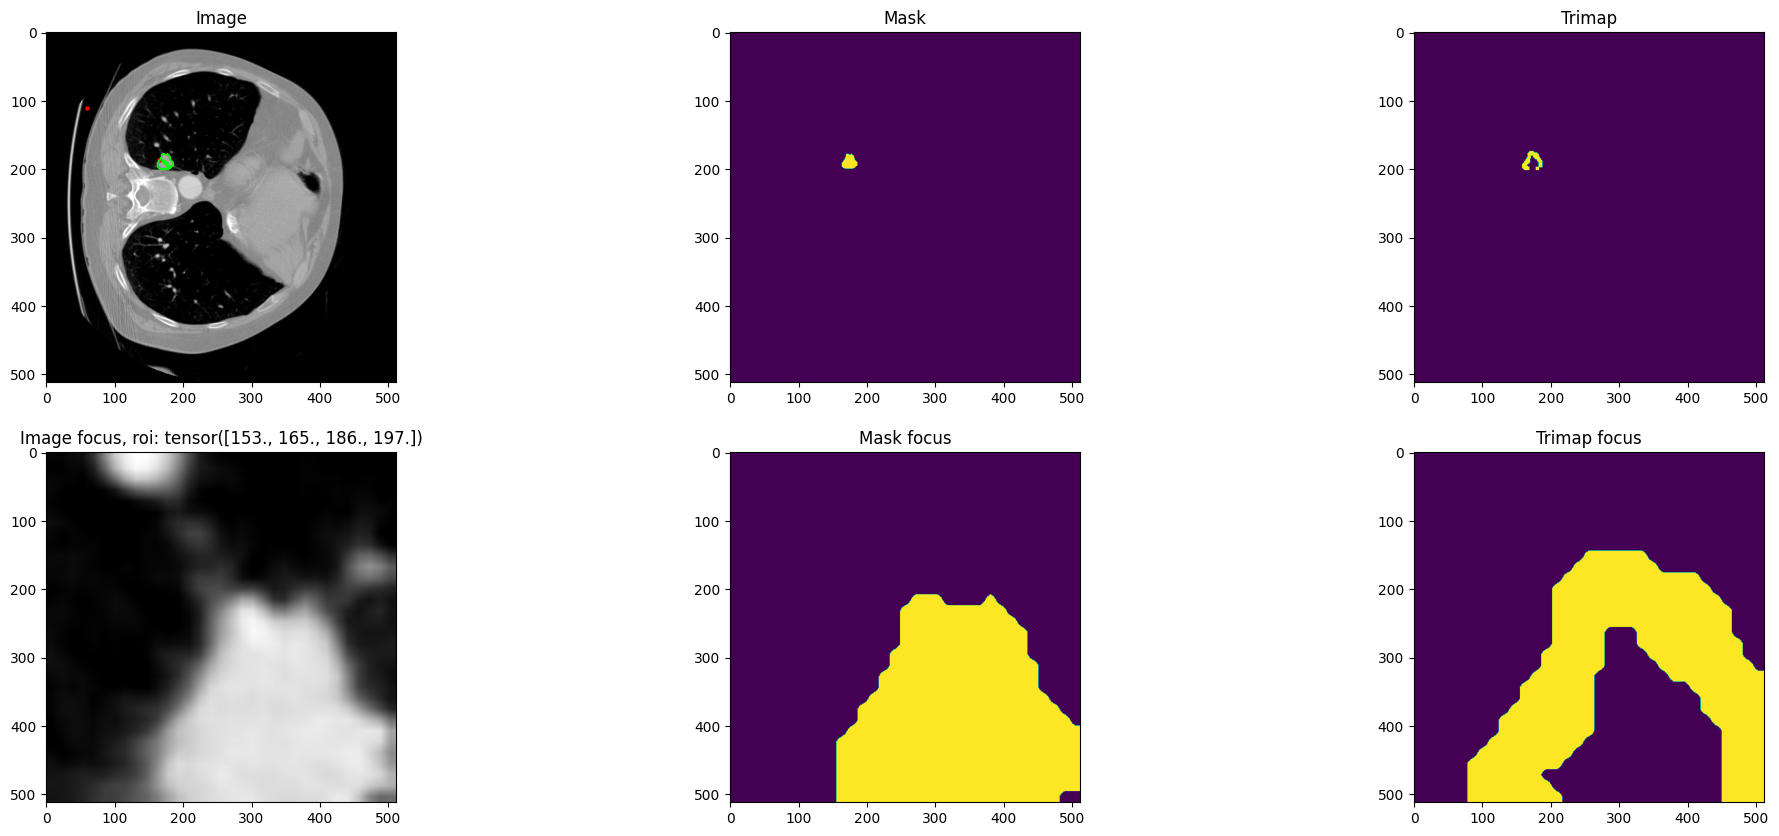

In [30]:
visualise_raw_batch(val_batch)

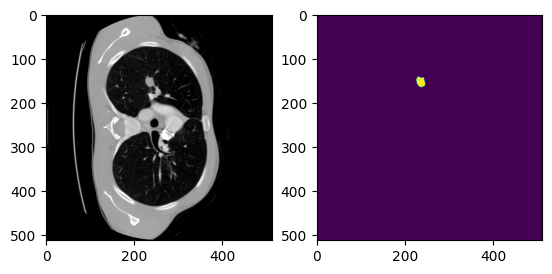

In [31]:
val_sample = val_set.get_sample(0)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(val_sample.image[:,:,0], cmap='gray')
ax[1].imshow(val_sample.gt_mask)

# Iterative evaluation test:

In [32]:
from isegm.ritm.inference.iterative_evaluation_training import (
    evaluate_dataset as iterative_evaluate_dataset,
)
from isegm.inference.predictors import get_predictor
from isegm.inference.utils import find_checkpoint_from_training, load_is_model

In [ ]:
# train_config = {'model_path':'models/ritm/hrnet32_3c_model.py'}
train_config = {'model_path':'models/focalclick/hrnet32_3c_model.py'}
device = torch.device('cuda:0')
TRAINING_OUTPUT_PATH = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training'
# checkpoint_path = find_checkpoint_from_training(TRAINING_OUTPUT_PATH, 'FocalClick_long_run', checkpoint_name='iterative_best_model.pth')

checkpoint_path = find_checkpoint_from_training(TRAINING_OUTPUT_PATH, 'RITMlong_run', checkpoint_name='iterative_best_model.pth')
print(checkpoint_path)
saved_model = load_is_model(checkpoint_path, 'cpu', train_config=train_config)
model = saved_model.to(device)
model = model.eval()

/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/training/2023-11-21/00-57-56-FocalClick_long_run/checkpoints/iterative_best_model.pth
model_class: <class 'isegm.model.is_hrnet_model.HRNetModel'>


In [34]:
predictor = get_predictor(
    model,
    'NoBRS',
    device,
    zoom_in_params=None
)
predictor

In [35]:
avg_ious, noc, nof, iterative_error = iterative_evaluate_dataset(
    val_set, predictor, logger
)
avg_ious, noc, nof, iterative_error

Running iterative NoC NoF evaluation
Running iterative NoC NoF evaluation


([0.6429954689775559,
  0.7610012812739552,
  0.7857145567324938,
  0.7997523708026244,
  0.8148785216586234,
  0.8234602501462114,
  0.8235773734477566,
  0.8324416215018388,
  0.8302562788913742,
  0.8336348737338489,
  0.8381544737269543,
  0.8369510848411352,
  0.8397469767260382,
  0.8452390571322135,
  0.844874979207948,
  0.8498741168277445,
  0.8509573947016132,
  0.8549269866729198,
  0.8570655047022484,
  0.8567914196486001],
 [8.295454545454545, 12.636363636363637, 18.363636363636363],
 [22, 42, 76],
 6.56704988141056)